In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.externals import joblib
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
import seaborn as sns
sns.set()

In [2]:
md_name = ['VAdjMat', 'MDEC.12', 'nAtomLAC', 'nAtomLC', 'khs.ssCH2', 'Kier1',
                   'Kier2', 'FMF', 'VP.1', 'C2SP3', 'nAtom', 'nAcid', 'mz']

In [3]:
N_set = pd.read_csv('./data/N_set.csv', index_col='all_cc_inx')

# tow components PCA
pca = PCA(n_components=2)
pca.fit(N_set[md_name])
N_set[['pca1', 'pca2']] = pd.DataFrame(pca.transform(N_set[md_name]), index=N_set.index, columns=['pca1', 'pca2'])
N_set.head()

,VAdjMat,MDEC.12,nAtomLAC,nAtomLC,khs.ssCH2,Kier1,Kier2,FMF,VP.1,C2SP3,nAtom,nAcid,mz,pca1,pca2
all_cc_inx,,,,,,,,,,,,,,,
all-cc-1,-0.597720,-0.281469,-0.382335,-0.721027,-0.745038,-0.850554,-0.725945,1.150500,-0.762142,-0.751629,-0.772242,-0.671111,-0.857964,-2.493644,-0.865522
all-cc-4,-0.811230,-0.554509,-0.382335,-0.890162,-0.745038,-0.967001,-0.785316,1.510575,-0.839023,-0.751629,-0.867863,-0.671111,-0.988711,-2.882674,-0.928287
all-cc-5,-0.153377,-0.357759,-0.218539,-0.721027,-0.490866,-0.692463,-0.676404,1.266832,-0.494136,-0.495726,-0.557096,-0.671111,-0.618211,-1.923593,-1.033581
all-cc-6,0.555162,0.241991,-0.054743,-0.382756,-0.490866,-0.182985,-0.404155,0.904910,-0.095370,-0.495726,-0.174613,-0.671111,0.017960,-0.697853,-1.214709
all-cc-7,1.217645,1.008986,-0.382335,-0.044486,-0.236695,0.425542,-0.215765,0.794290,0.863600,-0.069221,0.542541,-0.671111,1.063887,0.979871,-1.591609


#### BVGMM cluster

In [4]:
max_n_components = 100
dpgmm = BayesianGaussianMixture(
    n_components=max_n_components, covariance_type='full', weight_concentration_prior=100,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(13),
    init_params="kmeans", max_iter=1000, random_state=2)
dpgmm.fit(N_set[md_name])

BayesianGaussianMixture(covariance_prior=array([[ 1.,  0., ...,  0.,  0.],
       [ 0.,  1., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  1.,  0.],
       [ 0.,  0., ...,  0.,  1.]]),
            covariance_type='full', degrees_of_freedom_prior=None,
            init_params='kmeans', max_iter=1000, mean_precision_prior=0.01,
            mean_prior=None, n_components=100, n_init=1, random_state=2,
            reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
            warm_start=False, weight_concentration_prior=100,
            weight_concentration_prior_type='dirichlet_process')

In [5]:
N_set['cluster_inx'] = dpgmm.predict(N_set[md_name])

In [6]:
dpgmm_cluster_mean_pca = pd.DataFrame(data=pca.transform(dpgmm.means_), 
                                      columns=['pca1', 'pca2'], index=range(max_n_components))
dpgmm_cluster_mean_pca.head()

,pca1,pca2
0,2.819833e-01,7.535903e-01
1,6.042361e+00,3.293100e-01
2,6.032448e-16,1.050984e-16
3,-2.532838e+00,1.765700e+00
4,1.716544e+00,-1.373471e+00


In [7]:
cluster2count = {i: sum(N_set.cluster_inx==i) for i in np.unique(N_set.cluster_inx)}
cluster2count_df = pd.DataFrame(index=list(cluster2count.keys()), 
                                data=list(cluster2count.values()), columns=['compound_count'])
cluster2count_df.head()

,compound_count
0,19
1,42
3,53
4,3
6,14


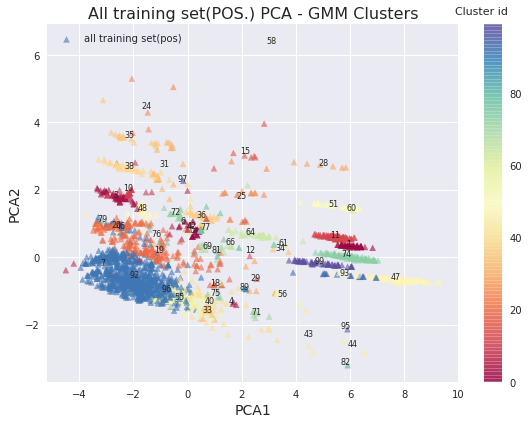

In [8]:
# cm = plt.cm.get_cmap('YlOrBr')
cm = plt.cm.get_cmap('Spectral')
plt.figure(figsize=(8, 6))
# current_cluster_inx = 39
plt.scatter(N_set['pca1'], N_set['pca2'],
            alpha=0.6, label='all training set(pos)', c=N_set.cluster_inx, 
            vmin=N_set.cluster_inx.min(), vmax=N_set.cluster_inx.max(), s=35, cmap=cm, marker='^')
cbar = plt.colorbar()
cbar.set_label('Cluster id', labelpad=-40, y=1.05, rotation=0)
# plt.scatter(N_set_pca['pca1'][cluster_inx==current_cluster_inx], N_set_pca['pca2'][cluster_inx==current_cluster_inx],
#             alpha=0.6, label='current cluster', c='g', s=75, marker='o')
# c=cluster_inx, 
# plt.title('Kernal PCA')
for i in cluster2count_df.index:
    current_center_x = dpgmm_cluster_mean_pca.loc[i, 'pca1']
    current_center_y = dpgmm_cluster_mean_pca.loc[i, 'pca2']
#     plt.text(current_center_x-0.2, current_center_y, 
#              str(i) + '-' + str(cluster2count_df.loc[i,'compound_count']), fontsize=10)
    plt.text(current_center_x-0.2, current_center_y, str(i), fontsize=8)
plt.title('All training set(POS.) PCA - GMM Clusters', size=16)
plt.xlabel('PCA1', size=14)
plt.ylabel('PCA2', size=14)
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('N_set_PCA_GMM_cluster.png', dpi=200)

#### remove small cluster

In [9]:
def leave_small_cluster_out(N_set_new, cluster_inx, cluster2count_df, md_name, min_compound_in_cluster=10):
    small_cluster_ids = cluster2count_df[cluster2count_df['count']<min_compound_in_cluster].cluster_inx
    N_set_new['cluster_inx'] = cluster_inx
    out_set = N_set_new[N_set_new.cluster_inx.isin(small_cluster_ids)]
    return out_set.index.tolist()

In [10]:
def get_stable_cluster(N_set, dpgmm, md_name, min_compound_in_cluster):
    out_set = []
    if_stop = False
    while 1:
        if if_stop:
            break
        # print(out_set)
        N_set_X = N_set[~N_set.index.isin(out_set)][md_name]
        dpgmm.fit(N_set_X)
        cluster_inx = dpgmm.predict(N_set_X)
        cluster2count = {i: sum(cluster_inx==i) for i in np.unique(cluster_inx)}
        cluster2count_df = pd.DataFrame(data={'cluster_inx': list(cluster2count.keys()), 
                                          'count': list(cluster2count.values())})
        # at least 11 compounds left
        leave_out_inx = leave_small_cluster_out(N_set_X, cluster_inx, cluster2count_df, 
                                                md_name, min_compound_in_cluster)
        if len(leave_out_inx)==0:
            if_stop=True
        else:
            out_set += leave_out_inx
    return out_set

In [11]:
out_set = get_stable_cluster(N_set, dpgmm, md_name, min_compound_in_cluster=11)

In [12]:
out_set[:5]

['all-cc-19', 'all-cc-113', 'all-cc-153', 'all-cc-215', 'all-cc-291']

In [13]:
N_set_new = N_set[~N_set.index.isin(out_set)][md_name]
dpgmm2 = BayesianGaussianMixture(
    n_components=max_n_components, covariance_type='full', weight_concentration_prior=100,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(13),
    init_params="kmeans", max_iter=1000, random_state=2)
dpgmm2.fit(N_set_new)
cluster_inx = dpgmm2.predict(N_set_new)
cluster2count2 = {i: sum(cluster_inx==i) for i in np.unique(cluster_inx)}
cluster2count_df2 = pd.DataFrame(data={'cluster_inx': list(cluster2count.keys()), 
                                  'count': list(cluster2count.values())})

In [14]:
V_set_small_cluster = N_set[N_set.index.isin(out_set)]
V_set_small_cluster.head()

,VAdjMat,MDEC.12,nAtomLAC,nAtomLC,khs.ssCH2,Kier1,Kier2,FMF,VP.1,C2SP3,nAtom,nAcid,mz,pca1,pca2,cluster_inx
all_cc_inx,,,,,,,,,,,,,,,,
all-cc-8,1.811656,3.423754,0.928031,-0.044486,0.186925,1.271477,0.179332,0.594692,1.597766,0.016080,1.331411,-0.671111,1.809658,3.315703,-2.458993,40
all-cc-19,-2.919718,-0.928406,-1.201314,-1.228433,-0.745038,-1.343472,-0.939081,1.732159,-1.315841,-0.751629,-1.226440,-0.671111,-1.489972,-4.495712,-0.388130,7
all-cc-113,1.359893,1.371485,0.764235,-0.213621,-0.406142,1.285256,0.263487,0.333135,1.191260,0.357284,1.379221,-0.671111,1.413467,2.422022,-1.623807,71
all-cc-153,-1.053287,-0.928406,-1.037518,-0.890162,-0.745038,-0.790719,-0.733580,-0.040517,-0.528630,-0.751629,-0.963483,-0.671111,-0.636443,-2.666243,0.052106,7
all-cc-189,0.658775,-0.229088,-0.218539,-0.129053,-0.067247,-0.064406,-0.258696,1.247443,0.167536,-0.154522,-0.007277,1.675769,0.083680,-0.216200,0.530807,6


In [15]:
def get_cluster_mean_pca(pca_model, dpgmm, max_cluster_n):
    dpgmm_cluster_mean_pca = pd.DataFrame(data=pca_model.transform(dpgmm.means_), 
                                      columns=['pca1', 'pca2'], index=range(max_cluster_n))
    return dpgmm_cluster_mean_pca

def draw_clusters(N_set_pca, N_set_new, cluster_inx, dpgmm_cluster_mean_pca, cluster2count, file_name=''):
    # cm = plt.cm.get_cmap('YlOrBr')
    cm = plt.cm.get_cmap('Spectral')
    plt.figure(figsize=(8, 6))
    # current_cluster_inx = 8
    plt.scatter(N_set_pca.loc[N_set_new.index, 'pca1'], 
                N_set_pca.loc[N_set_new.index, 'pca2'],
                alpha=0.9, label='', c=cluster_inx, 
                vmin=cluster_inx.min(), vmax=cluster_inx.max(), s=35, cmap=cm, marker='o')
    cbar = plt.colorbar()
    cbar.set_label('Cluster id', labelpad=-40, y=1.05, rotation=0)
    for i in cluster2count.keys():
        current_center_x = dpgmm_cluster_mean_pca.loc[i, 'pca1']
        current_center_y = dpgmm_cluster_mean_pca.loc[i, 'pca2']
        plt.text(current_center_x-0.2, current_center_y, str(i) + '-{}'.format(cluster2count[i]), fontsize=8)
    plt.title('New training set(POS) PCA - GMM Clusters-II', size=16)
    plt.xlabel('PCA1', size=14)
    plt.ylabel('PCA2', size=14)
    # plt.legend(loc='upper left')
    
    plt.tight_layout()
    if file_name:
        plt.savefig(file_name, dpi=300)

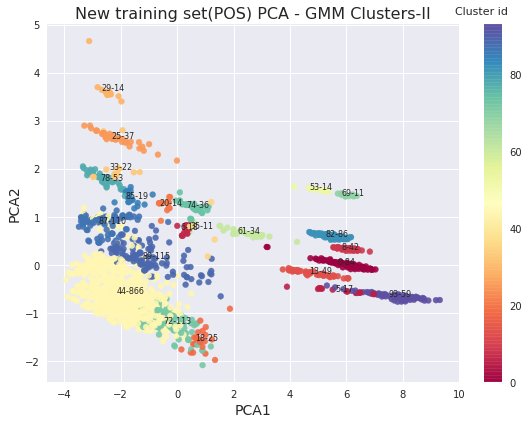

In [16]:
draw_clusters(N_set_new=N_set_new, N_set_pca=N_set[['pca1', 'pca2']], cluster_inx=cluster_inx, 
              cluster2count=cluster2count2, file_name='',
              dpgmm_cluster_mean_pca=get_cluster_mean_pca(pca_model=pca, dpgmm=dpgmm2, 
                                                          max_cluster_n=max_n_components))

#### add only point at the edge of cluster44 will change the way of clustering
#### 下面添加了一个点，但是聚类的结果发生了很大的变化

In [17]:
one_compound = V_set_small_cluster.loc['all-cc-19',:]
# one_compound = V_set_big_cluster_part.loc['all-cc-509',:]
print(one_compound.name)
N_set_new_plus_one = N_set_new.append(one_compound)
N_set_new_plus_one.shape

all-cc-19


(1850, 16)

In [18]:
dpgmm3 = BayesianGaussianMixture(
    n_components=100, covariance_type='full', weight_concentration_prior=100,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(13),
    init_params="kmeans", max_iter=1000, random_state=2)

In [19]:
dpgmm3.fit(N_set_new_plus_one[md_name])

BayesianGaussianMixture(covariance_prior=array([[ 1.,  0., ...,  0.,  0.],
       [ 0.,  1., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  1.,  0.],
       [ 0.,  0., ...,  0.,  1.]]),
            covariance_type='full', degrees_of_freedom_prior=None,
            init_params='kmeans', max_iter=1000, mean_precision_prior=0.01,
            mean_prior=None, n_components=100, n_init=1, random_state=2,
            reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
            warm_start=False, weight_concentration_prior=100,
            weight_concentration_prior_type='dirichlet_process')

In [20]:
cluster_inx3 = dpgmm3.predict(N_set_new_plus_one[md_name])
cluster_inx3

array([ 1,  1,  1, ..., 89,  1, 90])

In [21]:
dpgmm2_cluster_mean_pca3 = pd.DataFrame(data=pca.transform(dpgmm3.means_), 
                                      columns=['pca1', 'pca2'], index=range(100))
cluster2count3 = {i: sum(cluster_inx3==i) for i in np.unique(cluster_inx3)}
cluster2count_df3 = pd.DataFrame(data={'cluster_inx': list(cluster2count3.keys()), 
                                  'count': list(cluster2count3.values())})

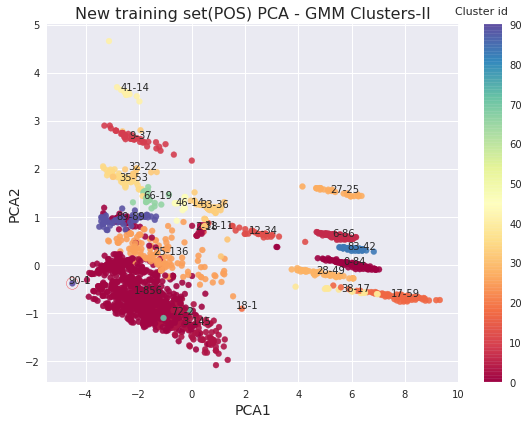

In [22]:
# cm = plt.cm.get_cmap('YlOrBr')
cm = plt.cm.get_cmap('Spectral')
plt.figure(figsize=(8, 6))
current_cluster_inx = 8
plt.scatter(N_set.loc[N_set_new_plus_one.index, 'pca1'], 
            N_set.loc[N_set_new_plus_one.index, 'pca2'],
            alpha=0.9, label='', c=cluster_inx3, 
            vmin=cluster_inx3.min(), vmax=cluster_inx3.max(), s=35, cmap=cm, marker='o')
cbar = plt.colorbar()
cbar.set_label('Cluster id', labelpad=-40, y=1.05, rotation=0)
plt.scatter(N_set.loc[[one_compound.name], 'pca1'],
            N_set.loc[[one_compound.name], 'pca2'],
            edgecolors='r', s=140, facecolors='none')
# c=cluster_inx, 
# plt.title('Kernal PCA')
for i in np.unique(cluster_inx3):
    current_center_x = dpgmm2_cluster_mean_pca3.loc[i, 'pca1']
    current_center_y = dpgmm2_cluster_mean_pca3.loc[i, 'pca2']
    plt.text(current_center_x-0.2, current_center_y, str(i) + '-{}'.format(cluster2count3[i]), fontsize=10)
plt.title('New training set(POS) PCA - GMM Clusters-II', size=16)
plt.xlabel('PCA1', size=14)
plt.ylabel('PCA2', size=14)
# plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('new_N_set_PCA_GMM_clusters-II_with_count.png', dpi=300)